# IT Job Classification using RNN (LSTM)

## Note: Please run this code in Google Colaboratory!!!

### How to Run this code
1. Upload this notebook to Google Drive
2. Create a directory called "Datasets" and upload "data job posts.csv" file to that directory.
3. Run this notebook in Google Colaboratory.

In [1]:
!pip install torch==0.4.1 torchvision==0.2.1

In [2]:
!pip install torchtext==0.3.1

In [3]:
!pip install gensim==3.6.0
!pip install -U -q PyDrive

In [4]:
!python -m spacy download en


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
from google.colab import auth

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# download google drive file
def download_drive_file(drive_directory, filename):
  list_file_query = "title='{}' and trashed=false".format(drive_directory)
  file_list = drive.ListFile({'q': list_file_query}).GetList()

  if len(file_list) > 0:
    directory_id = file_list[0]['id']

    list_file_query = "'{}' in parents".format(directory_id)

    file_list = drive.ListFile({'q': list_file_query}).GetList()
    
    file_id = None
    for file1 in file_list:
      if file1['title'] == filename:
        print("downloading file {}".format(file1['title']))
        file1.GetContentFile(file1['title'])

In [7]:
download_drive_file("Datasets", "data job posts.csv")

downloading file data job posts.csv


In [8]:
import pandas as pd

df = pd.read_csv("data job posts.csv")
df.head(5)

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\nI...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\nn...,NaN,2004,1,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\nPe...,NaN,23 January 2004\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\n- CV; \n-...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [0]:
df[["jobpost", "IT"]].to_csv("data_jobposts_it.csv", encoding="utf-8", index=False)

In [10]:
df = pd.read_csv("data_jobposts_it.csv")
df.head(5)

,jobpost,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,False
1,International Research & Exchanges Board (IREX...,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,True


# 2 - Updated Classification using RNN

In the previous notebook, we got the fundamentals down for sentiment analysis. In this notebook, we'll actually get decent results.

We will use:
* pre-trained word embeddings
* different RNN architecture
* bidirectional RNN
* multi-layer RNN
* regularization
* a different optimizer

This will allow us to achieve ~85% test accuracy.

## Preparing Data

The same as before, we'll set the seed, define the Fields and get the train/valid/test splits.

In [0]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(is_target=True, dtype=torch.float)

pos = data.TabularDataset(
    path='data_jobposts_it.csv', format='csv', 
    fields=[
        ('text', TEXT), 
        ('label', LABEL)
    ]
)

In [0]:
import random


train_data, test_data = pos.split(split_ratio=0.7, stratified=False, strata_field='label', random_state=random.seed(SEED))

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

We can see how many examples are in each split by checking their length.

In [13]:
print('len(train_data):', len(train_data))
print('len(valid_data):', len(valid_data))
print('len(test_data):', len(test_data))

len(train_data): 9311
len(valid_data): 3990
len(test_data): 5701


We can check the fields of the data, hoping that it they match the Fields given earlier.

In [14]:
print('train_data.fields:', train_data.fields)

train_data.fields: {'text': <torchtext.data.field.Field object at 0x7f022f4e0a90>, 'label': <torchtext.data.field.LabelField object at 0x7f022f4e0da0>}


We can also check an example.

In [15]:
print('vars(train_data[0]):', vars(train_data[0]))

vars(train_data[0]): {'text': ['Farm', 'Credit', 'Armenia', '\n', 'TITLE', ':', ' ', 'Software', 'Developers', '\n', 'TERM', ':', ' ', 'Full', 'time', '\n', 'DURATION', ':', ' ', 'Permanent', 'with', '3', 'months', 'trial', 'period', '\n', 'LOCATION', ':', ' ', 'Yerevan', ',', 'Armenia', '\n', 'JOB', 'DESCRIPTION', ':', ' ', 'We', 'are', 'looking', 'for', '2', 'Software', 'Developers', 'to', 'be', '\n', 'responsible', 'for', 'creation', 'of', 'Special', 'Database', 'for', 'Farm', 'Credit', 'Armenia', '\n', '(', 'FCA', ')', 'Universal', 'Credit', 'Company', '.', '\n', 'JOB', 'RESPONSIBILITIES', ':', '\n', '-', 'Organize', 'the', 'safety', 'of', 'information', 'about', 'clients', ';', '\n', '-', 'Organize', 'the', 'package', 'for', 'loan', 'analysis', ';', '\n', '-', 'Create', 'software', 'package', 'to', 'provide', 'Management', 'with', 'information', ';', '\n', '-', 'Create', 'a', 'project', 'program', 'for', 'assisting', 'the', 'decision', 'making', 'process', 'and', '\n', 'portfolio'

The first update, is the addition of pre-trained word embeddings. These vectors have been trained on corpuses of billions of tokens. Now, instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors, where words that appear in similar contexts appear nearby in this vector space.
The first step to using these is to specify the vectors and download them, which is passed as an argument to build_vocab. The glove is the algorithm used to calculate the vectors, go here for more. 6B indicates these vectors were trained on 6 billion tokens. 100d indicates these vectors are 100-dimensional.
Note: these vectors are about 862MB, so watch out if you have a limited internet connection.

In [0]:
TEXT.build_vocab(train_data, max_size=50000, vectors="glove.6B.100d")
LABEL.build_vocab(train_data)

As before, we create the iterators.

In [0]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE, 
    sort_key=lambda x: len(x.text), 
    repeat=False)

## Build the Model

The model features the most drastic changes.

### Different RNN Architecture

We use a different RNN architecture called a Long Short-Term Memory (LSTM). Why is an LSTM better than a standard RNN? The hidden state can be thought of as a "memory" of the words seen by the model. It is difficult to train a standard RNN as the gradient decays exponentially along the sequence, causing the RNN to "forget" what has happened earlier in the sequence. LSTMs have an extra recurrent state called a cell, which can be thought of as the "memory" of the LSTM and can remember information for many time steps. LSTMs also use multiple gates, these control the flow of information into and out of the memory. For more information, go [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

### Bidirectional RNN

The concept behind a bidirectional RNN is simple. As well as having an RNN processing the words in the sentence from the first to the last, we have a second RNN processing the words in the sentence from **the last to the first**. PyTorch simplifies this by concatenating both the forward and backward RNNs together, and thus the returned final hidden state, hidden, is the concatenation of the hidden state from the last word of the sentence from the forward RNN with the hidden state of the first word of the sentence from the backward RNN, both of which are the final hidden states from their respective RNNs.

![](https://camo.githubusercontent.com/9f462fe904900e9fc30a10101df3884fec700f60/68747470733a2f2f692e696d6775722e636f6d2f69746d494967782e706e67)

### Multi-layer RNN

Multi-layer RNNs (also called deep RNNs) are another simple concept. The idea is that we add additional RNNs on top of the initial standard RNN, where each RNN added is another layer. The hidden state output by the first (bottom) RNN at time-step $t$ will be the input to the RNN above it at time step $t$. The prediction is then usually made from the final hidden state of the final (highest) layer. These are easily combined with bi-directional RNNs, where each extra layer adds an additional forward and backward RNN.

![](https://camo.githubusercontent.com/0b711a2cae89c6b6bc3cc9e57a95d4f047d2116f/68747470733a2f2f692e696d6775722e636f6d2f6b6e73497a65682e706e67)

### Regularization

Although we've added improvements to our model, each one adds additional parameters. Without going into overfitting into to much detail, the more parameters you have in in your model, the higher the probability that you'll overfit (have a low train error but high validation/test error). To combat this, we use regularization. More specifically, we use a method of regularization called dropout. Dropout works by randomly dropping out (setting to 0) neurons during a forward pass. The probability that each neuron is dropped out is set by a hyperparameter and each neuron with dropout applied is considered indepenently. One theory about why dropout works is that a model with parameters dropped out can be seen as a "weaker" (less parameters) model, the predictions from all these "weaker" models (one for each forward pass) get averaged together in the parameters of the model. Thus, your one model can be thought of as an ensemble of weaker models, none of which are over-parameterized and thus should not overfit.

### Implementation Details

To use an LSTM instead of the standard RNN, we use nn.LSTM instead of nn.RNN on line 8. Also note on line 20 the LSTM returns the output and a tuple of the final hidden state and the final cell state, whereas the standard RNN only returned the output and final hidden state.

As the final hidden state of our LSTM has both a forward and a backward component, which are concatenated together, the size of the input to the nn.Linear layer is twice that of the hidden dimension size.

Implementing bidirectionality and adding additional layers are done by passing values for the num_layers and bidirectional arguments for the RNN/LSTM.

Dropout is implemented by initializing an nn.Dropout layer (the argument is the probability of dropout for each neuron) and using it within the forward method after each layer we want to apply dropout to. Note: never use dropout on the input or output layers (x or fc in this case), you only ever want to use dropout on intermediate layers. The LSTM has a dropout argument which adds dropout on the connections between hidden states in one layer to hidden states in the next layer.

In [0]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(x))
        
        #embedded = [sent len, batch size, emb dim]
        
        output, (hidden, cell) = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim * num directions]
        #hidden = [num layers * num directions, batch size, hid. dim]
        #cell = [num layers * num directions, batch size, hid. dim]
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
                
        #hidden [batch size, hid. dim * num directions]
            
        return self.fc(hidden.squeeze(0))

Like before, we'll create an instance of our RNN class, with the new parameters and arguments for the number of layers, bidirectionality and dropout probability.
To ensure the pre-trained vectors can be loaded into the model, the EMBEDDING_DIM must be equal to that of the pre-trained GloVe vectors loaded earlier.

In [19]:
INPUT_DIM = len(TEXT.vocab)
print("Input dimension:", INPUT_DIM)

EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)
print(model)

Input dimension: 35896
RNN(
  (embedding): Embedding(35896, 100)
  (rnn): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)


The final addition is copying the pre-trained word embeddings we loaded earlier into the embedding layer of our model.

We retrieve the embeddings from the field's vocab, and ensure they're the correct size, **[vocab size, embedding dim]**

In [20]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([35896, 100])


We then replace the initial weights of the embedding layer with the pre-trained embeddings.

In [21]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.2909, -0.7498, -0.2997,  ..., -0.4769,  0.4399, -0.2560],
        [-0.4200,  0.9484, -0.1327,  ...,  0.3052, -0.5236,  0.0954],
        [-0.4156,  1.2573, -0.1221,  ..., -0.1845, -0.6722, -0.0952]])

## Train the Model

Now to training the model.

The only change we'll make here is changing the optimizer from `SGD` to `Adam`. SGD updates all parameters with the same learning rate and choosing this learning rate can be tricky. Adam adapts the learning rate for each parameter, giving parameters that are updated more frequently lower learning rates and parameters that are updated infrequently higher learning rates. More information about Adam (and other optimizers) can be found [here](http://ruder.io/optimizing-gradient-descent/index.html).

To change `SGD` to `Adam`, we simply change `optim.SGD` to `optim.Adam,` also note how we do not have to provide an initial learning rate for Adam as PyTorch specifies a sensibile initial learning rate.

In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

The rest of the steps for training the model are unchanged.

We define the criterion and place the model and criterion on the GPU (if available)...

In [0]:
criterion = nn.BCEWithLogitsLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [0]:
import torch

def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

We define a function for training our model...

**Note:** as we are now using dropout, we must remember to use `model.train()` to ensure the dropout is "turned on" while training.

In [0]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text.to(device)).squeeze(1)
        
        loss = criterion(predictions, batch.label.to(device))
        
        acc = binary_accuracy(predictions, batch.label.to(device))
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We define a function for testing our model...

**Note:** as we are now using dropout, we must remember to use `model.eval()` to ensure the dropout is "turned off" while evaluating.

In [0]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text.to(device)).squeeze(1)
            
            loss = criterion(predictions, batch.label.to(device))
            
            acc = binary_accuracy(predictions, batch.label.to(device))

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Finally, we train our model...

In [36]:
N_EPOCHS = 5

for epoch in range(N_EPOCHS):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:.3f}, Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01, Train Loss: 0.370, Train Acc: 84.57%, Val. Loss: 0.225, Val. Acc: 92.64%
Epoch: 02, Train Loss: 0.167, Train Acc: 95.15%, Val. Loss: 0.184, Val. Acc: 94.37%
Epoch: 03, Train Loss: 0.124, Train Acc: 96.85%, Val. Loss: 0.132, Val. Acc: 96.48%
Epoch: 04, Train Loss: 0.096, Train Acc: 97.44%, Val. Loss: 0.192, Val. Acc: 95.41%
Epoch: 05, Train Loss: 0.080, Train Acc: 97.84%, Val. Loss: 0.106, Val. Acc: 96.50%


...and get our new and vastly improved test accuracy!

## Model Evaluation

Finally, the metric you actually care about, the test loss and accuracy.

In [0]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


Test Loss: 0.123, Test Acc: 96.46%


In [0]:
import torch

def to_binary(preds):
    """
    Convert predicted torch array to either 0 or 1
    """

    #round predictions to the closest integer
    return torch.round(torch.sigmoid(preds))

def predict(model, iterator):
    
    model.eval()
    
    all_predictions = []
    all_ids = []
    with torch.no_grad():
        for batch in iterator:
            
            predictions = to_binary(model(batch.text).squeeze(1)).cpu().numpy()
            all_ids += batch.id
            all_predictions += predictions.tolist()
            
    return all_predictions, all_ids

This is the confusion matrix based on predicted and actual test label.

In [0]:
test_predicted_labels, test_ids = predict(model, test_iterator)

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns


def print_confusion_matrix(confusion_matrix, class_names, figsize = (3.5,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


Figure(252x216)


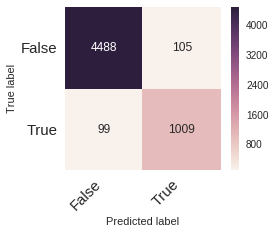

In [0]:
classes = ["False", "True"]
test_actual_labels = []
with torch.no_grad():
    for batch in test_iterator:
        test_actual_labels += batch.label.cpu().numpy().tolist()
        
cm = confusion_matrix(test_actual_labels, test_predicted_labels)
print(print_confusion_matrix(cm, class_names=classes))

In [0]:
precision, recall, fscore, support = precision_recall_fscore_support(test_actual_labels, test_predicted_labels)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=classes)
score_df

,f1-score,precision,recall,support
False,0.9778,0.9784,0.9771,4593
True,0.9082,0.9057,0.9106,1108


### Performance score using binary average

In [0]:
precision, recall, fscore, support = precision_recall_fscore_support(test_actual_labels, test_predicted_labels, average="binary")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.9082,0.9057,0.9106,None


### Performance score using micro average

In [0]:
precision, recall, fscore, support = precision_recall_fscore_support(test_actual_labels, test_predicted_labels, average="micro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.9642,0.9642,0.9642,None


### Performance score using macro average

In [0]:
precision, recall, fscore, support = precision_recall_fscore_support(test_actual_labels, test_predicted_labels, average="macro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.943,0.9421,0.9439,None


### Performance score using weighted average

In [0]:
precision, recall, fscore, support = precision_recall_fscore_support(test_actual_labels, test_predicted_labels, average="weighted")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,f1-score,precision,recall,support
score,0.9643,0.9643,0.9642,None


We can finally save our upgraded RNN model for IT job classification task.

In [0]:
torch.save(model, '02_lstm.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
!ls -lAh

total 210M
-rw-r--r-- 1 root root  23M Oct 11 08:41  02_lstm.pth
-rw-r--r-- 1 root root 2.5K Oct 11 06:48  adc.json
drwxr-xr-x 1 root root 4.0K Oct 11 06:48  .config
-rw-r--r-- 1 root root  90M Oct 11 06:48 'data job posts.csv'
-rw-r--r-- 1 root root  49M Oct 11 08:08  data_jobposts_it.csv
-rw-r--r-- 1 root root  49M Oct 11 06:48  data_jobposts_qualification.csv
drwxr-xr-x 2 root root 4.0K Oct  9 16:42  sample_data
drwxr-xr-x 2 root root 4.0K Oct 11 07:22  .vector_cache


In [0]:
from google.colab import files

files.download('02_lstm.pth') 

## Next Steps

We've now built a decent sentiment analysis model for movie reviews. However, not all of the steps we have added were necessary to achieve the test accuracy we've achieved. In the next notebook we'll implement a model that gets comparable accuracy with far fewer parameters and trains much, much faster.